# RL - TP4 - MC Control, Q-Learning and Expected Sarsa

In this notebook, you will:

- Implement MC Control for BlackJack
- Implement Q-Learning with $\epsilon$-greedy action selection
- Implement Expected Sarsa with $\epsilon$-greedy action selection
- Investigate how Q-Learning and Sarsa algorithms behave on Cliff World (described on page 132 of the textbook)

We will provide you with the environment and infrastructure to run the experiments. Do not forget to import all of the python scripts to your colab session (Files -> Upload to session storage). 

## Packages

You will need the following libraries for this assignment. We are using:
1. numpy: the fundamental package for scientific computing with Python.
2. scipy: a Python library for scientific and technical computing.
3. matplotlib: library for plotting graphs in Python.
4. RL-Glue: library for reinforcement learning experiments.


In [ ]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import agent
import cliffworld_env
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
import gym
import sys
from plot_utils import plot_blackjack_values, plot_policy



In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

# Section 1: MC Control on BlackJack



Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [ ]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

You will now write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [ ]:
# [Graded]
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done, info = ## YOUR CODE HERE 
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = ## YOUR CODE HERE
    best_a = ## YOUR CODE HERE
    policy_s[best_a] = ## YOUR CODE HERE
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = ## YOUR CODE HERE
        Q[state][actions[i]] = ## YOUR CODE HERE
    return Q

In [ ]:
# [Graded]
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = ## YOUR CODE HERE -- call the appropriate function
        # update the action-value function estimate using the episode
        Q = ## YOUR CODE HERE -- call the appropriate function
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Next, we plot the corresponding state-value function.

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [ ]:
# plot the policy
plot_policy(policy)

### Question:
Interpret the graph above.


## Section 2: Q-Learning

In this section you will implement and test a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the Sutton textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
# [Graded]
# Q-Learning agent here
class QLearningAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (1 line)
        ### START CODE HERE ###
        
        ### END CODE HERE ###
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        ### START CODE HERE ###
        
        ### END CODE HERE ###
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [ ]:
# Do not modify this cell

## Test Code for agent_start() ##

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

**Expected Output:**

```
Action Value Estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: 1
```

In [ ]:
# Do not modify this cell

## Test Code for agent_step() ##

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

**Expected Output:**

```
Action Value Estimates: 
 [[ 0.   0.2  0.   0. ]
 [ 0.   0.   0.  0.02]
 [ 0.   0.   0.   0. ]]
Actions: [1, 3, 1]
```

In [ ]:
# Do not modify this cell

## Test Code for agent_end() ##

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = QLearningAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
current_agent.agent_end(1)
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

**Expected Output:**

```
Action Value Estimates: 
 [[0.  0.2 0.  0. ]
 [0.  0.  0.  0.1]
 [0.  0.  0.  0. ]]
Actions: [1, 3]
```

## Section 3:  Expected Sarsa

In this section you will implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in the textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [ ]:
# [Graded]
# Expected Sarsa agent here
class ExpectedSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update (~5 lines)
        ### START CODE HERE ###
        
        ### END CODE HERE ###
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode (1 line)
        ### START CODE HERE ###
        
        ### END CODE HERE ###
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [ ]:
# Do not modify this cell

## Test Code for agent_start() ##

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
action = current_agent.agent_start(0)
print("Action Value Estimates: \n", current_agent.q)
print("Action:", action)

**Expected Output:**

```
Action Value Estimates: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action: 1
```

In [ ]:
# Do not modify this cell

## Test Code for agent_step() ##

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
actions.append(current_agent.agent_step(0, 0))
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

**Expected Output:**

```
Action Value Estimates: 
 [[0.     0.2    0.     0.    ]
 [0.     0.     0.     0.0185]
 [0.     0.     0.     0.    ]]
Actions: [1, 3, 1]
```

In [ ]:
# Do not modify this cell

## Test Code for agent_end() ##

actions = []
agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
current_agent = ExpectedSarsaAgent()
current_agent.agent_init(agent_info)
actions.append(current_agent.agent_start(0))
actions.append(current_agent.agent_step(2, 1))
current_agent.agent_end(1)
print("Action Value Estimates: \n", current_agent.q)
print("Actions:", actions)

**Expected Output:**

```
Action Value Estimates: 
 [[0.  0.2 0.  0. ]
 [0.  0.  0.  0.1]
 [0.  0.  0.  0. ]]
Actions: [1, 3]
```

## Section 4:  Solving the Cliff World

The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.
Also, this is an undiscounted episodic task and thus we set $\gamma$=1.

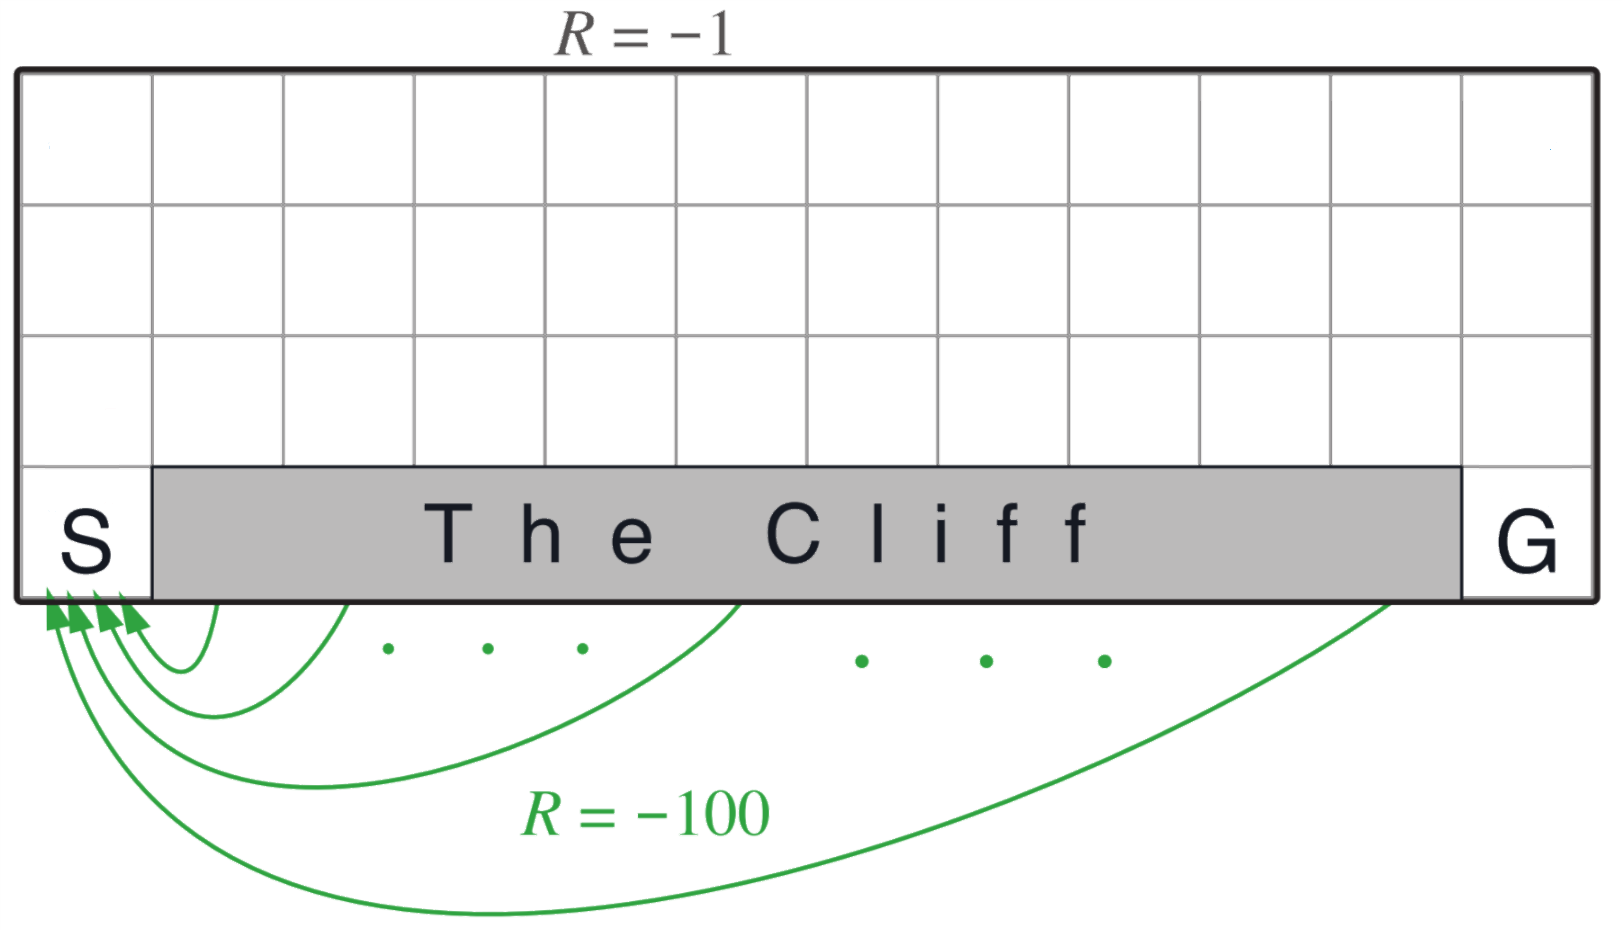

Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.



100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


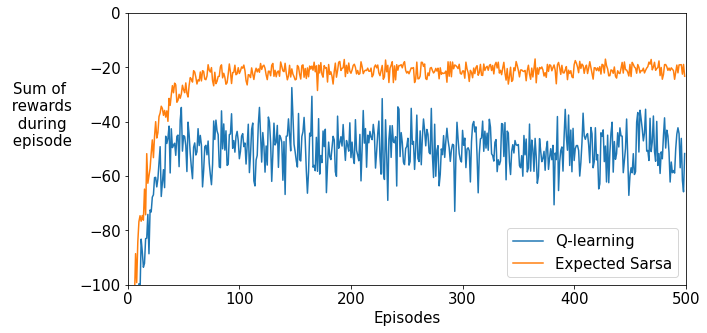

In [ ]:
# Do not modify this cell

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 500 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
#         last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(0) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            reward_sums.append(rl_glue.rl_return())
#             last_episode_total_reward = rl_glue.rl_return()
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)

# save results
import os
import shutil
os.makedirs('results', exist_ok=True)
np.save('results/q_learning.npy', all_reward_sums['Q-learning'])
np.save('results/expected_sarsa.npy', all_reward_sums['Expected Sarsa'])
shutil.make_archive('results', 'zip', '.', 'results')

        
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)
plt.ylim(-100,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


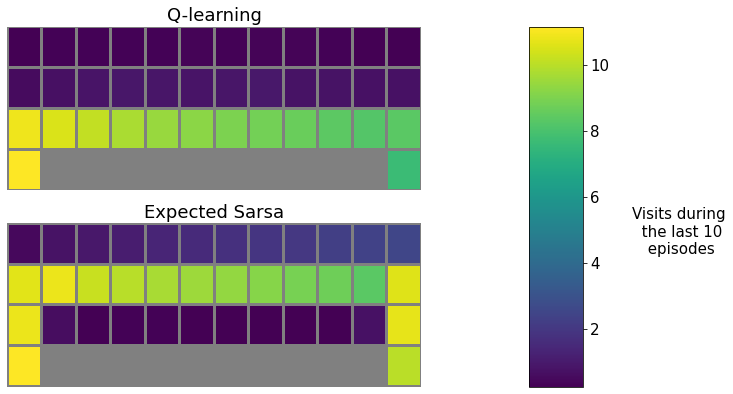

In [ ]:
# Do not modify this cell

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

### Question: 
Interpret the plot above.

Answer:





Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


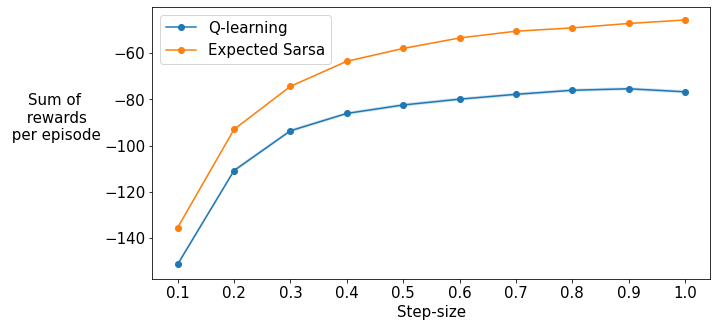

In [ ]:
# Do not modify this cell

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Q-learning", "Expected Sarsa"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

### Question:
Interpret the graph above.


## Wrapping up

Congratulations! Now you have:
- implemented MC control for BlackJack
- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these last two algorithms on Cliff World

